In [36]:
import h5py
import numpy as np
from scipy.stats import ortho_group
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
mat = h5py.File('IPCADATA_FNW36_RNKDMN_CON.mat')
mat_t = np.transpose(mat['X'])
np.save('test.npy', mat_t)
X= np.load('test.npy')
W= np.transpose(mat['W'])
np.save('test.npy', W)
W= np.load('test.npy')
Nts= np.transpose(mat['Nts'])
np.save('test.npy', Nts)
Gamma_Old,s,v=svds(X, k=5)
Gamma_Old.shape

(37, 5)

In [37]:
 def num_IPCA_estimate_ALS(Gamma_Old , W , X , Nts):
    import matlab.engine
    eng = matlab.engine.start_matlab()

    F_New =[]
    for t in range(599):
        #a=np.linalg.inv(Gamma_Old.T@W[:,:,t]@Gamma_Old)@( Gamma_Old.T@X[:,t])
        a=Gamma_Old.T@W[:,:,t]@Gamma_Old
        b=Gamma_Old.T@X[:,t]
        n=np.linalg.lstsq(a,b,rcond=None)[0]
        F_New.append(n)
    F_New=np.matrix(F_New).T
    L=37
    K=5
    Ktilde = K
    Denom = np.zeros(L*Ktilde)
    Numer = np.zeros((L*Ktilde,1))
    Nts=np.concatenate(Nts.reshape(1,-1).T)
    for t in range(599):
        Numer = Numer + (np.kron( X[:,1] , F_New[:,1].T )*Nts[1]).T
        Denom = Denom + np.kron(W[:,:,t], F_New[:,t]@F_New[:,t].transpose())*Nts[t]  
    Gamma_New_trans_vec=np.linalg.inv(Denom)@Numer
    Gamma_New_trans     = np.reshape(Gamma_New_trans_vec,(Ktilde,L))
    Gamma_New           = Gamma_New_trans.T
    F_New.shape        
    
    R1                  = eng.chol(Gamma_New.T@Gamma_New,'upper')
    np.save('test.npy', R1)
    R1= np.load('test.npy')
    R2,_,_            = np.linalg.svd(R1@F_New@F_New.T@R1.T)

    Gamma_New =Gamma_New@np.linalg.inv(R1)@R2
    A=R1@F_New
    x=np.linalg.lstsq(R2,A)
    m=x[0]
    F_New=np.array(m)
    
    return Gamma_New,F_New 

In [38]:
GB_New,F_New=num_IPCA_estimate_ALS(Gamma_Old , W , X , Nts)


/var/folders/wp/90sg7791331gjh98thrw3ryh0000gn/T/ipykernel_73467/1014158823.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x=np.linalg.lstsq(R2,A)


In [39]:
tol         = 1
iters        = 0
F_Old       = np.ones((5,599))
while iters<=10 and tol>1e-6:
    GB_New,F_New = num_IPCA_estimate_ALS(Gamma_Old,W,X,Nts)
    tol     = max(abs(GB_New-Gamma_Old).max(),abs(F_New-F_Old).max())
    F_Old   = F_New
    GB_Old  = GB_New
    iters   = iters+1
GB_GB= GB_New
GB_F = F_New


/var/folders/wp/90sg7791331gjh98thrw3ryh0000gn/T/ipykernel_73467/1014158823.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x=np.linalg.lstsq(R2,A)


In [40]:
GB=np.concatenate((np.zeros((37,1), dtype=int), GB_GB), axis=1)


In [41]:
GB_Old      = GB
F_Old       = GB_F
tol         = 1
iters        = 0
while iters<=10 and tol>1e-6:
    GB_New,F_New = num_IPCA_estimate_ALS(Gamma_Old,W,X,Nts)
    tol     = max(abs(GB_New-Gamma_Old).max(),abs(F_New-F_Old).max())
    F_Old   = F_New
    GB_Old  = GB_New
    iters   = iters+1
GBGA_GB      = GB_New[:,0:5]
GBGA_GA      = GB_New[:,-1]
GBGA_F       = F_New
GBGA_GB.shape

/var/folders/wp/90sg7791331gjh98thrw3ryh0000gn/T/ipykernel_73467/1014158823.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x=np.linalg.lstsq(R2,A)


(37, 5)

In [42]:
vb=[]
for i in range(599):
    vb.append(np.random.normal(0,1,1))
vb=np.array(vb) 

va=[]
for i in range(599):
    va.append(np.random.normal(0,1,1))
va=np.array(va) 


f=[]
for i in range(5):
    f.append(np.random.normal(0,1,1))
f=np.array(f)

e=[]
for i in range(599):
    e.append(np.random.normal(0,1,1))
e=np.array(e)

Z=[]
for i in range(599):
    Z.append(np.random.normal(0,1,37))
Z=np.array(Z) 


beta=vb+Z@GBGA_GB
alpha=va+Z@GBGA_GA

r=alpha+beta@f+e


In [43]:
Z=[]
X=[]
for i in range(599):
    Z.append(np.random.normal(0,1,37))
    x=Z[i].reshape(1,-1).reshape(1,-1)
    X.append(x)
Z=np.array(Z) 
X=np.array(X)

X=X.reshape(37,599)
X.shape

(37, 599)


### simulation  to get gammabeta hat and gammaalpha hat

In [44]:
Gamma_Old,s,v=svds(X, k=5)
GB_New,F_New=num_IPCA_estimate_ALS(Gamma_Old , W , X , Nts)
tol         = 1
iters        = 0
F_Old       = np.ones((5,599))
while iters<=10 and tol>1e-6:
    GB_New,F_New = num_IPCA_estimate_ALS(Gamma_Old,W,X,Nts)
    tol     = max(abs(GB_New-Gamma_Old).max(),abs(F_New-F_Old).max())
    F_Old   = F_New
    GB_Old  = GB_New
    iters   = iters+1
GB_GB= GB_New
GB_F = F_New
GB=np.concatenate((np.zeros((37,1), dtype=int), GB_GB), axis=1)
GB_Old      = GB
F_Old       = GB_F
tol         = 1
iters        = 0
while iters<=10 and tol>1e-6:
    GB_New,F_New = num_IPCA_estimate_ALS(Gamma_Old,W,X,Nts)
    tol     = max(abs(GB_New-Gamma_Old).max(),abs(F_New-F_Old).max())
    F_Old   = F_New
    GB_Old  = GB_New
    iters   = iters+1
GBGA_GB      = GB_New[:,0:5]
GBGA_GA      = GB_New[:,-1]
GBGA_F       = F_New

/var/folders/wp/90sg7791331gjh98thrw3ryh0000gn/T/ipykernel_73467/1014158823.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x=np.linalg.lstsq(R2,A)


### find the estimated r with estimated gammabeta and gammaalpha

In [63]:
from numpy import matrix
def sim():    
    vb=[]
    for i in range(599):
        vb.append(np.random.normal(0,1,1))
    vb=np.array(vb) 

    va=[]
    for i in range(599):
        va.append(np.random.normal(0,1,1))
    va=np.array(va) 

    Z=[]
    for i in range(599):
        Z.append(np.random.normal(0,1,37))
    Z=np.array(Z) 
    Z.shape

    f=[]
    for i in range(5):
        f.append(np.random.normal(0,1,1))
    f=np.array(f)

    e=[]
    for i in range(599):
        e.append(np.random.normal(0,1,1))
    e=np.array(e)

    beta=vb+Z@GBGA_GB
    alpha=va+Z@GBGA_GA

    r_estimated=alpha+beta@f+e
    rs=abs(r-r_estimated)
    rd=abs(r-np.mean(r))
    sum_squared_regression = sum(num ** 2 for num in rs)
    total_sum_of_squares = sum(num ** 2 for num in rd)
    total_sum_of_squares
    r_squared=1-sum_squared_regression/total_sum_of_squares 
    l=float(r_squared)
    return l
sim()

-0.6008226479634433

### R_squared metrics calculation:
the authors' code calculated the predicted r_squared of pred_GammaBeta to be 0.69%

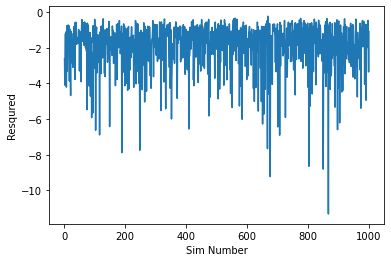

In [66]:
num_simulations = 1000
balance =list(range(1000))
num_rolls =list(range(1000))

for i in range(num_simulations):
 
    balance[i]=sim()
    num_rolls[i]=i+1
    
fig = plt.figure()

plt.xlabel("Sim Number")
plt.ylabel("Resqured")
plt.plot(num_rolls, balance)
 
   